Backtest of a USA Growth-Trend strategy using USA OECD leading indicator

# **weekly model**

- If short-term change in OECD is positive: stay invested in S&P500 index (conservative: no dividends assumed, just price)
- If short-term change in OECD is negative, switch to trend following modus on S&P500 index.
		- If medium-term price trend S&P 500 is positive: stay invested in S&P 500 index.
        - If medium-term price trend S&P 500 is negative: switch to cash (conservative:0% interest rate assumed)
        
No transaction costs assumed..
The code pulls in SPX price from Yahoo finance and OECD from OECD API.

In [13]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from datetime import date
from datetime import timedelta
import math


In [14]:
#Get weekly data for S&P500 (ex-dividend) from Yahoo finance, drop columns and rename a column
start = datetime(1955,1,1)
end=datetime.now()
sp500_daily=yf.download('^GSPC',start,end,interval='1d')
sp500_weekly=sp500_daily.resample('w').last()
sp500_weekly=sp500_weekly.drop(columns=['High','Low','Open','Volume','Close'])
sp500_weekly=sp500_weekly.rename(columns={'Adj Close':'Close'})
print(sp500_weekly.tail(20))

[*********************100%***********************]  1 of 1 completed
                  Close
Date                   
2022-11-06  3770.550049
2022-11-13  3992.929932
2022-11-20  3965.340088
2022-11-27  4026.120117
2022-12-04  4071.699951
2022-12-11  3934.379883
2022-12-18  3852.360107
2022-12-25  3844.820068
2023-01-01  3839.500000
2023-01-08  3895.080078
2023-01-15  3999.090088
2023-01-22  3972.610107
2023-01-29  4070.560059
2023-02-05  4136.479980
2023-02-12  4090.459961
2023-02-19  4079.090088
2023-02-26  3970.040039
2023-03-05  4045.639893
2023-03-12  3861.590088
2023-03-19  3919.290039


In [15]:
#Get monthly US OECD leading indicator data
url='https://stats.oecd.org/SDMX-JSON/data/MEI_CLI/LOLITOAA.USA.M/all?startTime=1947-02&endTime=2023-02&dimensionAtObservation=allDimensions'
r=requests.get(url)
oecd_file=r.json()
#get the US oecd values from the json file in a list
oecd_us_values=[]
oecd_us_dates=[]
for k in oecd_file['dataSets'][0]['observations']:
    oecd_us_values.append(oecd_file['dataSets'][0]['observations'][k][0])
#get the US oecd dates from the json file in a list
for k in oecd_file['structure']['dimensions']['observation'][3]['values']:
    oecd_us_dates.append(k['id'])
#create dictionary of US oecd dates and values and then transform it to a dataframe
oecd_dict={'Date':oecd_us_dates,'values':oecd_us_values}
oecd_df=pd.DataFrame(oecd_dict)
oecd_df=oecd_df.set_index('Date')
oecd_df.index=pd.to_datetime(oecd_df.index)
#resample in weekly data and fill na values with previous values
oecd_df=oecd_df.resample('w').last()
oecd_df=oecd_df.fillna(method='ffill')

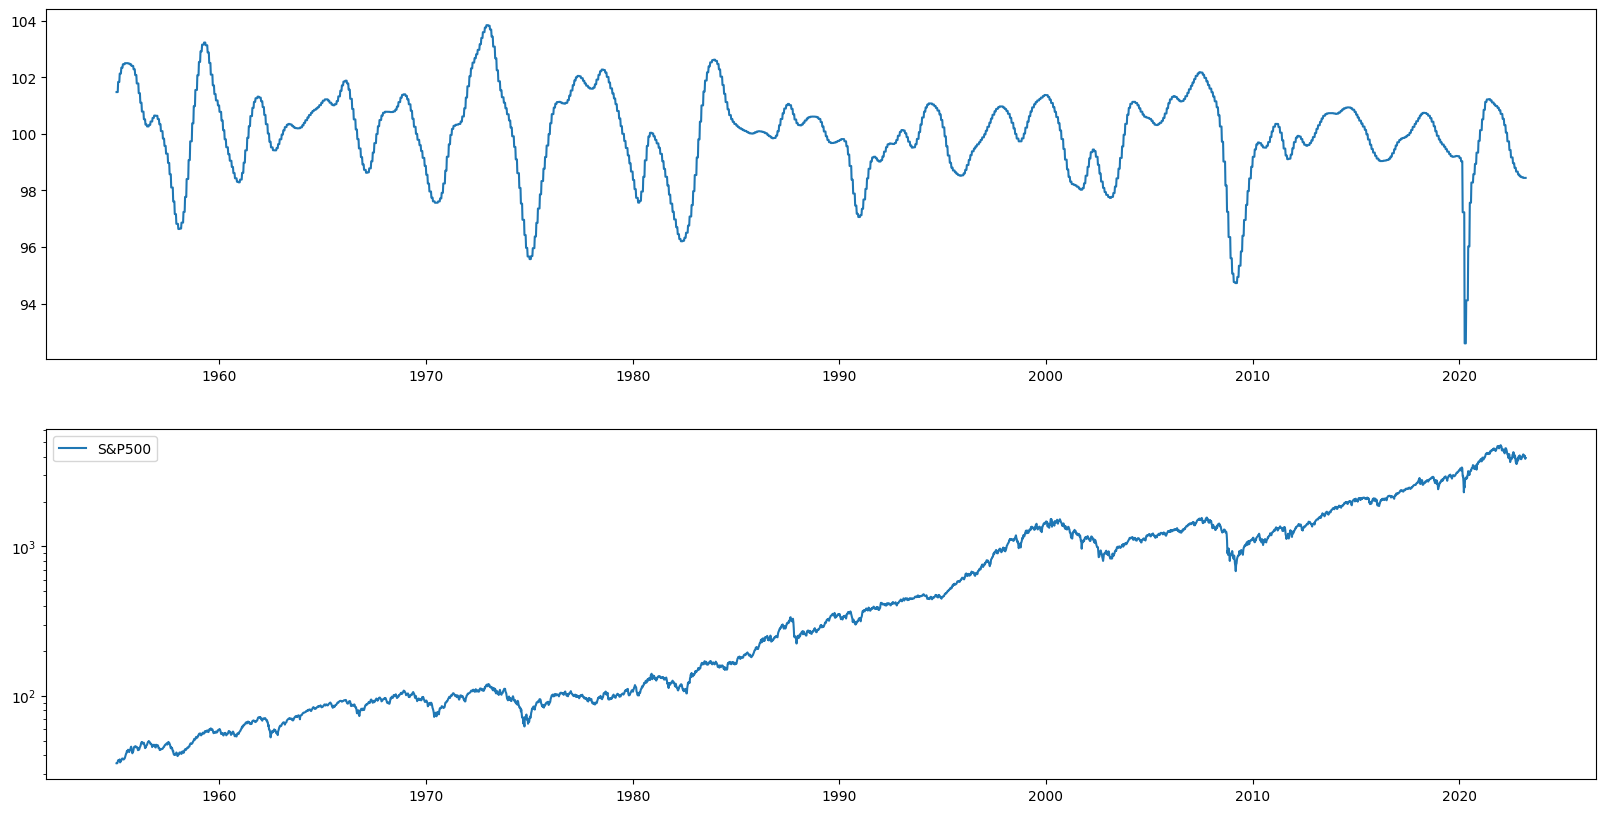

,sp500_close,oecd_value
Date,,
1955-01-09,35.330002,101.48130
1955-01-16,35.279999,101.48130
1955-01-23,35.439999,101.48130
1955-01-30,36.189999,101.48130
1955-02-06,36.959999,101.83910
...,...,...
2023-02-19,4079.090088,98.44531
2023-02-26,3970.040039,98.44531
2023-03-05,4045.639893,98.44531


In [28]:
#merge SP500 weekly and OECD weekly dataframes, merge on DAte from SP500_weekly, fill na values in OECD with previous values
us_df=pd.merge_ordered(sp500_weekly,oecd_df,how='left',on='Date',fill_method='ffill')
us_df=us_df.rename(columns={'Close':'sp500_close','values':'oecd_value'})
us_df=us_df.set_index('Date')
fig,ax=plt.subplots(2,1)
plt.rcParams['figure.figsize'] = [20, 10]
ax[0].plot(us_df.index,us_df['oecd_value'],label='US_leading_oecd')
ax[1].semilogy(us_df.index,us_df['sp500_close'],label='S&P500')
plt.legend()
plt.show()
us_df

In [30]:
#Calculate weekly return on sp500,x-week moving average on sp500,  y-week roc on OECD value, 
us_df['sp500_return']=us_df['sp500_close'].pct_change()
sp500_ma=50 
us_df['sp500_ma']=us_df['sp500_close'].rolling(sp500_ma).mean()
oecd_roc=15
us_df['oecd_roc']=us_df['oecd_value'].diff(periods=15) #15 weeks!!! not months
us_df=us_df[['sp500_close','sp500_ma','sp500_return','oecd_value','oecd_roc']]
us_df.tail(50)


,sp500_close,sp500_ma,sp500_return,oecd_value,oecd_roc
Date,,,,,
2022-04-10,4488.279785,4445.362412,-0.012666,100.04470,-0.79480
2022-04-17,4392.589844,4449.590811,-0.021320,100.04470,-0.66440
2022-04-24,4271.779785,4450.374404,-0.027503,100.04470,-0.66440
2022-05-01,4131.930176,4449.536006,-0.032738,99.73771,-0.97139
2022-05-08,4123.339844,4448.885605,-0.002079,99.73771,-0.97139
2022-05-15,4023.889893,4445.281206,-0.024119,99.73771,-0.97139
2022-05-22,3901.360107,4438.710605,-0.030451,99.73771,-0.79699
2022-05-29,4158.240234,4436.926611,0.065844,99.73771,-0.79699
2022-06-05,4108.540039,4435.768408,-0.011952,99.43115,-1.10355


In [31]:
#calculate trading signals: if OECD-roc is negative: switch to trendfollowing on sp500
#(if price sp500 below ma, not in market elseif in market) else if oecd-roc is positive: in market

us_df=us_df.copy()
conditions = [
    (pd.isnull(us_df['sp500_ma'])),
    (us_df['oecd_roc'] <=0) & (us_df['sp500_close'] <=us_df['sp500_ma']),
    (us_df['oecd_roc'] <=0) & (us_df['sp500_close'] >us_df['sp500_ma']),
    (us_df['oecd_roc'] >0)
]

values = [np.nan,0,1,1]

us_df['trade_signal'] = np.select(conditions, values)
us_df['trade_signal']=us_df['trade_signal'].astype('float')
us_df.tail(30)


,sp500_close,sp500_ma,sp500_return,oecd_value,oecd_roc,trade_signal
Date,,,,,,
2022-08-28,4057.659912,4333.615200,-0.040398,98.96595,-0.77176,0.0
2022-09-04,3924.260010,4323.440596,-0.032876,98.80187,-0.93584,0.0
2022-09-11,4067.360107,4315.678198,0.036465,98.80187,-0.93584,0.0
2022-09-18,3873.330078,4306.003999,-0.047704,98.80187,-0.62928,0.0
2022-09-25,3693.229980,4292.041802,-0.046497,98.80187,-0.62928,0.0
2022-10-02,3585.620117,4274.326802,-0.029137,98.66790,-0.76325,0.0
2022-10-09,3639.659912,4256.222002,0.015071,98.66790,-0.76325,0.0
2022-10-16,3583.070068,4235.775806,-0.015548,98.66790,-0.50213,0.0
2022-10-23,3752.750000,4216.880210,0.047356,98.66790,-0.50213,0.0


In [19]:
#Calculate return signal: if previous trade signal was 1, return1
us_df['return_signal']=us_df['trade_signal'].shift(1)
#calculate strategy return based on return signal
us_df['strat_return']=us_df['return_signal']*us_df['sp500_return']
#calculate cum_return for strategy
us_df['strat_cum_return']=(1 + us_df['strat_return']).cumprod()
#calculate new return column for benchmark with aligned missing values
conditions = [
    (pd.isnull(us_df['strat_cum_return'])),
    (pd.notnull(us_df['strat_cum_return']))    
]
values = [np.nan,us_df['sp500_return']]
us_df['bench_return'] = np.select(conditions, values)
#calculate cum_return for benchmark
us_df['bench_cum_return']=(1 + us_df['bench_return']).cumprod()
us_df[1:60]

,sp500_close,sp500_ma,sp500_return,oecd_value,oecd_roc,trade_signal,return_signal,strat_return,strat_cum_return,bench_return,bench_cum_return
Date,,,,,,,,,,,
1955-01-16,35.279999,NaN,-0.001415,101.4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-01-23,35.439999,NaN,0.004535,101.4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-01-30,36.189999,NaN,0.021163,101.4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-06,36.959999,NaN,0.021277,101.8391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-13,37.150002,NaN,0.005141,101.8391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-20,36.889999,NaN,-0.006999,101.8391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-27,36.570000,NaN,-0.008674,101.8391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-03-06,37.520000,NaN,0.025978,102.1352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-03-13,35.820000,NaN,-0.045309,102.1352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#resample the weekly return to end of month returns and save the strat return series to CSV

strat_return_series=(us_df['strat_return']+1).resample('M').prod()
strat_return_series=strat_return_series-1
strat_return_series.index.rename('date',inplace=True)
strat_return_series.name='oecd_return'
strat_return_series.to_csv('oecd_return.csv')
strat_return_series

date
1955-01-31    0.000000
1955-02-28    0.000000
1955-03-31    0.000000
1955-04-30    0.000000
1955-05-31    0.000000
                ...   
2022-11-30    0.000000
2022-12-31    0.000000
2023-01-31    0.000000
2023-02-28   -0.024694
2023-03-31   -0.045493
Freq: M, Name: oecd_return, Length: 819, dtype: float64

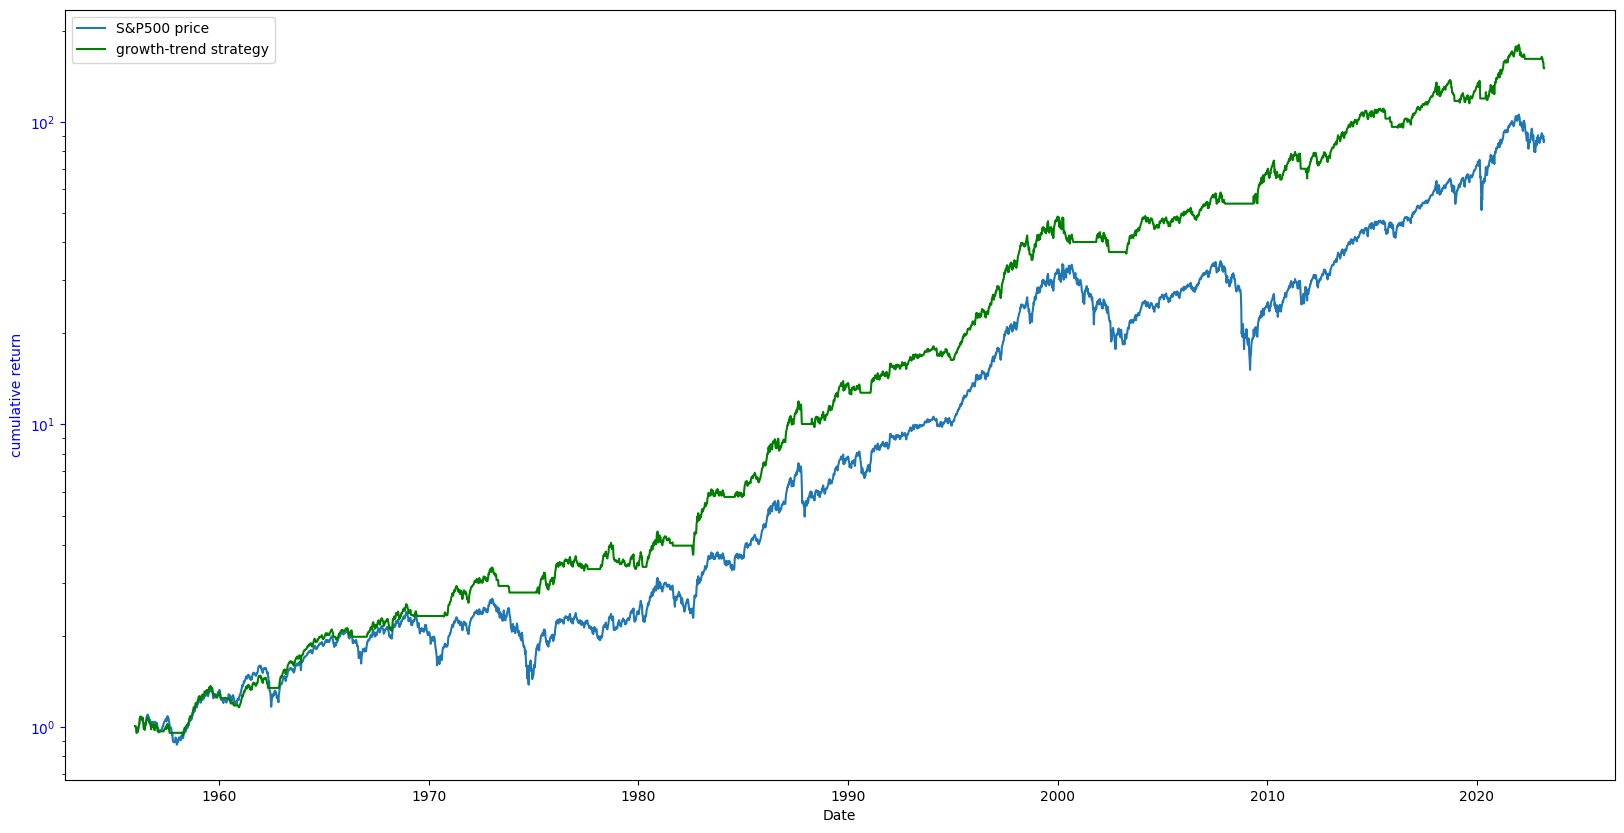

In [21]:
#Quick plot of strategy return (ex dividend, ex interest earned on cash return) versus benchmark return
fig,ax=plt.subplots()
ax.plot(us_df.index,us_df['bench_cum_return'],label='S&P500 price')
ax.plot(us_df.index,us_df['strat_cum_return'],color='green',label='growth-trend strategy')
ax.set(yscale="log")
ax.set_xlabel('Date')
ax.set_ylabel('cumulative return',color='blue')
ax.tick_params('y',colors='blue')
plt.legend(loc="upper left")

In [22]:
#Calculate CAGR strat
total_ret_strat = us_df['strat_cum_return'][-1]
start = datetime.utcfromtimestamp(us_df.index.values[0].astype('O')/1e9)
end = datetime.utcfromtimestamp(us_df.index.values[-1].astype('O')/1e9)
period_years = (end - start).days / 365.25
CAGR_strat = (total_ret_strat)**(1/period_years) - 1
CAGR_strat
#Calculate CAGR bench
total_ret_bench = us_df['bench_cum_return'][-1]
start = datetime.utcfromtimestamp(us_df.index.values[0].astype('O')/1e9)
end = datetime.utcfromtimestamp(us_df.index.values[-1].astype('O')/1e9)
period_years = (end - start).days / 365.25
CAGR_bench = (total_ret_bench)**(1/period_years) - 1
CAGR_bench
#calculate vol of strat
start = datetime.utcfromtimestamp(us_df.index.values[0].astype('O')/1e9)
end = datetime.utcfromtimestamp(us_df.index.values[-1].astype('O')/1e9)
period_years = (end - start).days / 365.25
ratio_to_annual = us_df['strat_return'].count() / period_years
vol_strat = us_df["strat_return"].std() * math.sqrt(ratio_to_annual)
#calculate vol of bench
start = datetime.utcfromtimestamp(us_df.index.values[0].astype('O')/1e9)
end = datetime.utcfromtimestamp(us_df.index.values[-1].astype('O')/1e9)
period_years = (end - start).days / 365.25
ratio_to_annual = us_df['bench_return'].count() / period_years
vol_bench = us_df["bench_return"].std() * math.sqrt(ratio_to_annual)

In [23]:
model_dict={"S&P500 price":[CAGR_bench*100,vol_bench*100,CAGR_bench/vol_bench],"Growth-Trend strategy":[CAGR_strat*100,vol_strat*100,CAGR_strat/vol_strat]}
model_df=pd.DataFrame(model_dict)
index_list=['CAGR %','Volatility %','Quick Sharpe']
model_df['stats (1970 - now)']=index_list
model_df.set_index('stats (1970 - now)')

,S&P500 price,Growth-Trend strategy
stats (1970 - now),,
CAGR %,6.765743,7.626074
Volatility %,15.448052,11.108469
Quick Sharpe,0.437967,0.686510
